In [2]:
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain

from libs.networks import ImpNet
from libs.losses import MSELoss, LNCCLoss, NCCLoss, JacobianLossCoords, ExclusionLossCoords
from libs.data import make_coords_tensor, fast_bilinear_color_interpolation, MetricMonitor

# Load and scale the ISH (moving) and nissl (fixed) images. 

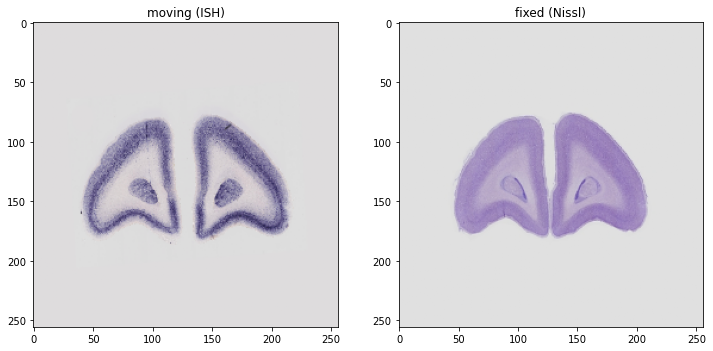

In [4]:
sidelength = 256
color_dim = 3
spatial_size = (sidelength, sidelength)
inv_spatial_size = (420, 360)

moving = cv2.imread('data/ish.png', 1) 
moving = cv2.cvtColor(moving, cv2.COLOR_BGR2RGB)
moving = cv2.resize(moving, spatial_size).astype(np.float32) / 255.0

fixed = cv2.imread('data/nissl.jpg', 1)
fixed = cv2.cvtColor(fixed, cv2.COLOR_BGR2RGB)
fixed = cv2.resize(fixed, spatial_size).astype(np.float32) / 255.0  

coords_init = make_coords_tensor(dims=(sidelength, sidelength))

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(moving)
axes[1].imshow(fixed)
axes[0].set_title('moving (ISH)')
axes[1].set_title('fixed (Nissl)')
plt.show()

moving = moving*2-1 
fixed = fixed*2-1 

Define three identical implicit networks: the deformation network, the support network, and the residual network.  

In [5]:
device = 'cuda'

deformation_network = ImpNet(input_dim=2, output_dim=2, hidden_dim=256, hidden_n_layers=5, last_layer_weights_small=True,
                             is_last_linear=True, input_omega_0=30.0, hidden_omega_0=30., input_n_encoding_functions=6).to(device)

support_network = ImpNet(input_dim=2, output_dim=3, hidden_dim=256, hidden_n_layers=5, last_layer_weights_small=False,
                         is_last_linear=True, input_omega_0=30.0, hidden_omega_0=30., input_n_encoding_functions=6).to(device)

residual_network = ImpNet(input_dim=2, output_dim=3, hidden_dim=256, hidden_n_layers=5, last_layer_weights_small=False,
                          is_last_linear=True, input_omega_0=30.0, hidden_omega_0=30., input_n_encoding_functions=6).to(device)

epochs = 200 # one epoch corresponds to all image pixel coordinates
epochs_til_summary = 100 # generate visualizations every 100 epochs

params = chain(deformation_network.parameters(), support_network.parameters(), residual_network.parameters())
optimizer = torch.optim.AdamW(lr=0.0001, params=params)

# Define the loss function as in the paper: 

$$Loss = \alpha_{1} \mathcal{L}_{cc}(F, T_{\Phi}(M)) + \alpha_{2}\mathcal{L}_{cc}(F, T_{\Phi}(M_S)) + 
 \alpha_{3} \mathcal{L}_{reg}(\Phi(\bar{x})) +  \alpha_{4} \mathcal{L}_{rec}(M, M_S+M_R) + \alpha_{5} \mathcal{L}_{excl}(M_S, M_R).  $$

In [6]:
ncc = NCCLoss(is_tensor=False).to(device)
lncc = LNCCLoss(win=(32, 32), n_channels=color_dim, is_tensor=False).to(device)
reg = JacobianLossCoords(add_identity=False, is_tensor=False).to(device)
excl = ExclusionLossCoords(add_identity=False).to(device)
mse = MSELoss().to(device)

alpha_1 = alpha_2 = 1
alpha_3 = 1
alpha_4 = 100
alpha_5 = 1

In [7]:
moving_image = torch.from_numpy(moving)
moving_image = moving_image.to(device, dtype=torch.float32).permute(2, 0, 1)
fixed_image = torch.from_numpy(fixed)
fixed_image = fixed_image.to(device, dtype=torch.float32).permute(2, 0, 1)

moving_image = torch.unsqueeze(moving_image, 0)
fixed_image = torch.unsqueeze(fixed_image, 0)
image_coords = coords_init.to(device)

# Main training loop:

Epoch: 99. Train. mse loss: 1.4911 | reg loss: 0.0575 | ncc loss: -1.6610 | decomposition loss: 0.0806 | loss: -0.0319:

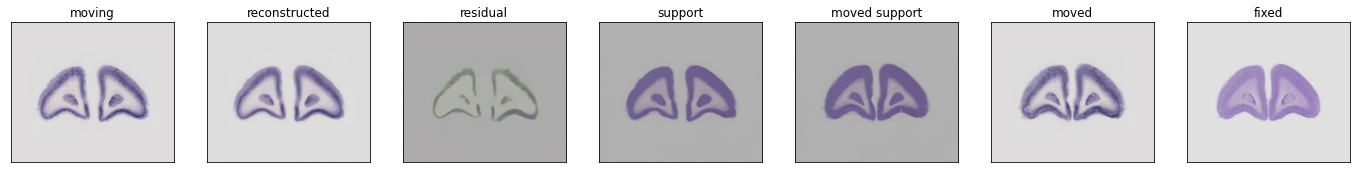

Epoch: 199. Train. mse loss: 0.8229 | reg loss: 0.0556 | ncc loss: -1.7330 | decomposition loss: 0.0531 | loss: -0.8014

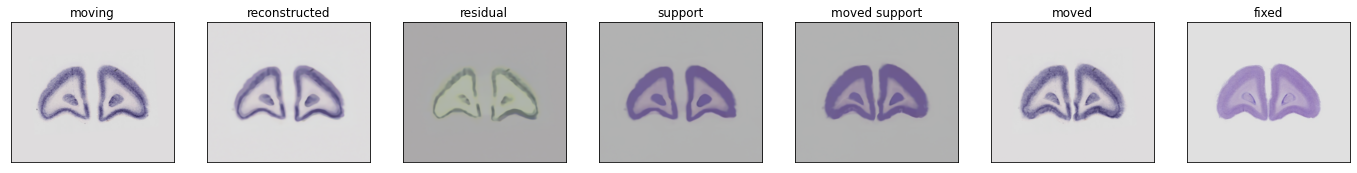

Epoch: 199. Train. mse loss: 0.8229 | reg loss: 0.0556 | ncc loss: -1.7330 | decomposition loss: 0.0531 | loss: -0.8014


In [8]:
stream = tqdm(range(epochs))
loop_monitor = MetricMonitor()

for epoch in stream:
            
    flow, coords = deformation_network(image_coords)
    flow_add = coords + flow
    
    support_pixels = support_network(coords, clone=False)
    residual_pixels = residual_network(coords, clone=False)
    
    recon_moving_pixels = support_pixels + residual_pixels
    recon_moving_image = recon_moving_pixels.view(sidelength, sidelength, color_dim).permute(2, 0, 1).unsqueeze(0)
    
    support_image = support_pixels.view(sidelength, sidelength, color_dim).permute(2, 0, 1).unsqueeze(0)
    residual_image = residual_pixels.view(sidelength, sidelength, color_dim).permute(2, 0, 1).unsqueeze(0)
    
    moved_image = fast_bilinear_color_interpolation(moving_image[0,:,:,:], flow_add[:,0], flow_add[:,1]).view(sidelength, sidelength, color_dim).permute(2, 0, 1)
    moved_image = torch.unsqueeze(moved_image, 0)
    
    moved_support_image = fast_bilinear_color_interpolation(support_image[0,:,:,:], flow_add[:,0], flow_add[:,1]).view(sidelength, sidelength, color_dim).permute(2, 0, 1)
    moved_support_image = torch.unsqueeze(moved_support_image, 0)    
        
    ##
    
    loss_all = torch.tensor(0)
    
    loss_mse = mse(moving_image, recon_moving_image) 
    loss_ncc = (ncc(moved_image, fixed_image) + lncc(moved_image, fixed_image)) / 2
    loss_ncc_support = (ncc(moved_support_image, fixed_image) + lncc(moved_support_image, fixed_image)) / 2
    loss_jac = reg(coords, flow_add)
    loss_ncc_full = loss_ncc+loss_ncc_support
    loss_excl = excl(coords, support_pixels, residual_pixels)
    
    if alpha_4>0:
        
        loss_all = loss_all + alpha_4*loss_mse
    
    if alpha_1>0:

        loss_all = loss_all + alpha_1*loss_ncc_full        

    if alpha_3>0:

        loss_all = loss_all + alpha_3*loss_jac   
        
    if alpha_5>0:
        
        loss_all = loss_all + alpha_5*loss_excl
          
    loop_monitor.update('mse loss', alpha_4*loss_mse.item())
    loop_monitor.update('reg loss', alpha_3*loss_jac.item())
    loop_monitor.update('ncc loss', alpha_1*loss_ncc_full.item())
    loop_monitor.update('decomposition loss', alpha_5*loss_excl.item())
    loop_monitor.update('loss', loss_all.item())
    stream.set_description('Epoch: {epoch}. Train. {metric_monitor}'.format(epoch=epoch, metric_monitor=loop_monitor))

    optimizer.zero_grad()
    loss_all.backward()
    optimizer.step()
    
    if not (epoch+1) % epochs_til_summary:
          
        temp_moved = moved_image.cpu().detach().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5
        temp_recon = recon_moving_image.cpu().detach().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5
        temp_support = support_pixels.cpu().detach().view(sidelength, sidelength, color_dim).numpy() * 0.5 + 0.5
        temp_residual = residual_pixels.cpu().detach().view(sidelength, sidelength, color_dim).numpy() * 0.5 + 0.5
        temp_moved_support = moved_support_image.cpu().detach().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5
        temp_moving = moving_image.cpu().detach().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5
        temp_fixed = fixed_image.cpu().detach().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5

        temp_moving = cv2.resize(temp_moving, inv_spatial_size).astype(np.float32) 
        temp_moved = cv2.resize(temp_moved, inv_spatial_size).astype(np.float32)  
        temp_recon = cv2.resize(temp_recon, inv_spatial_size).astype(np.float32)  
        temp_support = cv2.resize(temp_support, inv_spatial_size).astype(np.float32)  
        temp_residual = cv2.resize(temp_residual, inv_spatial_size).astype(np.float32)  
        temp_moved_support = cv2.resize(temp_moved_support, inv_spatial_size).astype(np.float32) 
        temp_fixed = cv2.resize(temp_fixed, inv_spatial_size).astype(np.float32) 
        
        fig, axes = plt.subplots(1,7, figsize=(24,48))
        axes[0].imshow(temp_moving, vmin=0, vmax=1)
        axes[1].imshow(temp_recon, vmin=0, vmax=1)
        axes[2].imshow(temp_residual, vmin=0, vmax=1)
        axes[3].imshow(temp_support, vmin=0, vmax=1)
        axes[4].imshow(temp_moved_support, vmin=0, vmax=1)
        axes[5].imshow(temp_moved, vmin=0, vmax=1)
        axes[6].imshow(temp_fixed)

        for k in range(7):
            
            axes[k].set_xticks([])
            axes[k].set_yticks([])
            
        axes[0].set_title('moving')
        axes[1].set_title('reconstructed')
        axes[2].set_title('residual')
        axes[3].set_title('support')
        axes[4].set_title('moved support')
        axes[5].set_title('moved')
        axes[6].set_title('fixed')
        
        plt.show()    
        
        
    